In [1]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

/usr/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)


In [2]:
dataset = pd.read_csv('sign_mnist_train.csv')

In [3]:
dataset.shape

(27455, 785)

In [4]:
dataset.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [31]:
pixels = dataset.ix[:,1:].values.astype('float32')
label = dataset.ix[:,0].values.astype('int32')

#Normalization
pixels /= 255

pixels = pixels.reshape(pixels.shape[0], 28, 28, 1)

print (pixels.shape)
print (label.shape)

(27455, 28, 28, 1)
(27455,)


In [7]:
idx2alph = {0:'a',1:'b',2:'c',3:'d',4:'e',5:'f',6:'g',7:'h',8:'i',9:'j',10:'k',11:'l',12:'m',13:'n',14:'o',
            15:'p',16:'q',17:'r',18:'s',19:'t',20:'u',21:'v',22:'w',23:'x',24:'y',25:'z'}

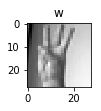

In [9]:
a=7
plt.subplot(330 + a)
plt.imshow(pixels[a], cmap=plt.get_cmap('gray'))
plt.title(idx2alph[label[a]])
plt.show()

In [13]:
# one-hot vector
from keras.utils.np_utils import to_categorical
label = to_categorical(label, 26)
print (label.shape)

(27455, 26)


## Model code

In [5]:
def zero_pad(X, pad):
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=0) 
    return X_pad

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)


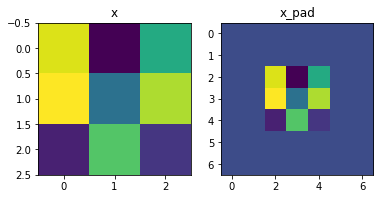

In [7]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

In [9]:
def conv_single_step(a_slice_prev, W, b):
    s = np.multiply(a_slice_prev, W) + b
    Z = np.sum(s)
    return Z

In [10]:
def conv_forward(A_prev, W, b, hparameters):
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape

    stride = hparameters['stride']
    pad = hparameters['pad']
    
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1
    
    Z = np.zeros((m, n_H, n_W, n_C))
    
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                                 # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]                     # Select ith training example's padded activation
        for h in range(n_H):                           # loop over vertical axis of the output volume
            for w in range(n_W):                       # loop over horizontal axis of the output volume
                for c in range(n_C):                   # loop over channels (= #filters) of the output volume
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[...,c], b[...,c])
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [11]:
np.random.seed(1)
A_prev = np.random.randn(1, 5, 5, 1)
W = np.random.randn(2, 3, 3, 1)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 2,
               "stride": 1}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean = 3.9125516483785905


IndexError: index 1 is out of bounds for axis 0 with size 1

In [16]:
## Hyperparameters
image_size = 28
num_channels = 1
filter_size = 3
depth = 4
hidden1 = 256
learning_rate = 0.1
beta = 0

num_classes = 26

In [15]:
#sigmoid
def sigmoid(X):
    return 1/(1+np.exp(-1*X))

#softmax
def softmax(X):
    exp_X = np.exp(X)
    sum_exp_X = np.sum(exp_X,1).reshape(-1,1)  #col-wise sum
    exp_X = exp_X/sum_exp_X
    return exp_X

### Initialize Weights

    conv_layer1_weights = [3,3,1,4]
    conv_layer2_weights = [3,3,4,16]
    full_layer1_weights = [504,256]
    full_layer2_weights = [256,10] 

In [17]:
 def initialize_parameters():
    #initialize weights values with 0 mean and 0.5 standard deviation.
    mean = 0
    std = 0.5
    
    #conv layer weights
    conv_layer1_weights = np.random.normal(mean,std,(filter_size,filter_size,num_channels,depth))
    conv_layer1_biases = np.zeros([1,depth])
    conv_layer2_weights = np.random.normal(mean,std,(filter_size,filter_size,depth,depth*4))
    conv_layer2_biases = np.zeros([1,depth*4])
    
    #fully-connected weights
    full_layer1_weights = np.random.normal(mean,std,(((image_size//4-1) * (image_size//4-1) * depth * 4),hidden1))
    full_layer1_biases = np.zeros([hidden1])
    full_layer2_weights = np.random.normal(mean,std,(hidden1,num_classes))
    full_layer2_biases = np.zeros([num_classes])
    
    parameters = dict()
    parameters['cw1'] = conv_layer1_weights
    parameters['cb1'] = conv_layer1_biases
    parameters['cw2'] = conv_layer2_weights
    parameters['cb2'] = conv_layer2_biases
    parameters['fw1'] = full_layer1_weights
    parameters['fb1'] = full_layer1_biases
    parameters['fw2'] = full_layer2_weights
    parameters['fb2'] = full_layer2_biases
    
    return parameters

In [18]:
def conv_multiply(image,weights):
    hsize = (image.shape[0]-weights.shape[0])//2 + 1
    vsize = (image.shape[1]-weights.shape[1])//2 + 1
    logits = np.zeros([hsize,vsize,weights.shape[3]])
    for d in range(weights.shape[3]):
        row = 0
        for rpos in range(0,(image.shape[0]-filter_size+1),2):
            col=0
            for cpos in range(0,(image.shape[1]-filter_size+1),2):
                logits[row,col,d] = np.sum(np.multiply(image[rpos:rpos+filter_size, cpos:cpos+filter_size, :],weights[:,:,:,d]))
                col += 1
            row+=1
    return logits

In [19]:
#FORWARD PROPAGATION
def forward_propagation(dataset,parameters):
    #convolution layers activations
    m = dataset.shape[0]
    
    #get the parameters
    cw1 = parameters['cw1']
    cb1 = parameters['cb1']
    cw2 = parameters['cw2']
    cb2 = parameters['cb2']
    
    fw1 = parameters['fw1']
    fb1 = parameters['fb1']
    fw2 = parameters['fw2']
    fb2 = parameters['fb2']
    
    #to store the intermediate activations for backward propagation
    cache = dict()
    
    conv_activation1 = list()
    conv_activation2 = list()
    
    #image by image convolutional forward propagation
    for i in range(m):
        image = dataset[i]
        logits = conv_multiply(image,cw1) + cb1
        ca1 = sigmoid(logits)
        ca2 = sigmoid(conv_multiply(ca1,cw2) + cb2).reshape((image_size // 4 -1) * (image_size // 4 -1) * depth * 4)
        
        conv_activation1.append(ca1)
        conv_activation2.append(ca2)
        
    #convert into numpy array
    conv_activation1 = np.array(conv_activation1).reshape(m,image_size // 2 -1, image_size // 2 -1, depth)
    conv_activation2 = np.array(conv_activation2).reshape(m,image_size // 4 -1, image_size // 4 -1, depth * 4)
        
    #expand the conv_activation2 into (m,num_features) 
    #num_features = (image_size // 4 * image_size // 4 * depth * 4)
    temp_activation = np.array(conv_activation2).reshape(m,(image_size // 4 -1) * (image_size // 4-1) * depth * 4)
    
    #fully connected layers activations
    full_activation1 = np.matmul(temp_activation,fw1) + fb1
    full_activation1 = sigmoid(full_activation1)
    full_activation2 = np.matmul(full_activation1,fw2) + fb2
    output = softmax(full_activation2)
    
    cache['ca1'] = conv_activation1
    cache['ca2'] = conv_activation2
    cache['fa1'] = full_activation1
    cache['output'] = output
    return cache,output

In [21]:
#calculate conv deltas or errors only for one example
def conv_delta(next_error,weights):
    delta = np.zeros([next_error.shape[0]*2+1,next_error.shape[1]*2+1,next_error.shape[2]//4])
    for d in range(weights.shape[3]):
        row = 0
        for rpos in range(0,delta.shape[0]-filter_size+1,2):
            col=0
            for cpos in range(0,delta.shape[2]-filter_size+1,2):
                delta[rpos:rpos+filter_size,cpos:cpos+filter_size,:] += weights[:,:,:,d]*next_error[row,col,d]
                col+=1
            row +=1
    return delta

In [22]:
#conv partial derivatives only for single example
def conv_derivatives(delta,activation):
    partial_derivatives = np.zeros([filter_size,filter_size,activation.shape[2],delta.shape[2]])
    for d2 in range(0,partial_derivatives.shape[3]):
        row=0
        for rpos in range(0,activation.shape[0]-filter_size+1,2):
            col = 0
            for cpos in range(0,activation.shape[1]-filter_size+1,2):
                partial_derivatives[:,:,:,d2] += np.multiply(activation[rpos:rpos+filter_size, cpos:cpos+filter_size, :],delta[row,col,d2])
                col += 1
            row += 1
    return partial_derivatives

In [23]:
def backward_propagation(dataset,labels,cache,parameters):
    #get activations
    output = cache['output']
    fa1 = cache['fa1']
    ca2 = cache['ca2']
    ca1 = cache['ca1']
    
    temp_act = np.array(ca2).reshape(-1,(image_size // 4-1) * (image_size // 4 -1)* depth * 4)
    
    #get parameters
    cw1 = parameters['cw1']
    cw2 = parameters['cw2']
    fw1 = parameters['fw1']
    fw2 = parameters['fw2']
    
    
    #cal errors fully connected
    error_fa2 = output - labels
    error_fa1 = np.matmul(error_fa2,fw2.T)
    error_fa1 = np.multiply(error_fa1,fa1)
    error_fa1 = np.multiply(error_fa1,(1-fa1))
    error_temp = np.matmul(error_fa1,fw1.T)
    error_temp = np.multiply(error_temp,temp_act)
    error_temp = np.multiply(error_temp,(1-temp_act))
    
    m = dataset.shape[0]
    
    #cal errors conv layers
    error_ca2 = np.array(error_temp).reshape(-1,image_size//4-1,image_size//4-1,depth*4)
    error_ca1 = np.zeros(ca1.shape)
    ## Image by Image error
    for i in range(m):
        error = conv_delta(error_ca2[i],cw2)
        error = np.multiply(error,ca1[i])
        error = np.multiply(error,(1-ca1[i]))
        error_ca1 += error
    
    
    #calculate partial derivatives
    #fully connected layers
    fd2 = (np.matmul(fa1.T,error_fa2) + beta*fw2)/m
    fd1 = (np.matmul(temp_act.T,error_fa1) + beta*fw1)/m
    
    #conv layers
    cd2 = np.zeros(cw2.shape)
    cd1 = np.zeros(cw1.shape)
    
    ##Image by Image derivatives
    for i in range(m):
        cd2 = cd2 + conv_derivatives(error_ca2[i],ca1[i])
        cd1 = cd1 + conv_derivatives(error_ca1[i],dataset[i])
    cd2 = (cd2 + beta*cw2)/m
    cd1 = (cd1 + beta*cw1)/m
    
    
    #store the derivatives in dict
    derivatives = dict()
    
    derivatives['cd1'] = cd1
    derivatives['cd2'] = cd2
    derivatives['fd1'] = fd1
    derivatives['fd2'] = fd2
    
    return derivatives

In [24]:
def update_parameters(derivatives,parameters):
    #get parameters
    cw1 = parameters['cw1']
    cw2 = parameters['cw2']
    fw1 = parameters['fw1']
    fw2 = parameters['fw2']
    
    #get derivatives
    cd1 = derivatives['cd1']
    cd2 = derivatives['cd2']
    fd1 = derivatives['fd1']
    fd2 = derivatives['fd2']
    
    #update
    cw1 = cw1 - learning_rate*cd1
    cw2 = cw2 - learning_rate*cd2
    fw1 = fw1 - learning_rate*fd1
    fw2 = fw2 - learning_rate*fd2
    
    #update the dict
    parameters['cw1'] = cw1
    parameters['cw2'] = cw2
    parameters['fw1'] = fw1
    parameters['fw2'] = fw2
    
    return parameters

In [25]:
def cal_loss_accuracy(true_labels,predictions,parameters):
    #get parameters
    cw1 = parameters['cw1']
    cw2 = parameters['cw2']
    fw1 = parameters['fw1']
    fw2 = parameters['fw2']
    
    m = len(true_labels)
    
    #cal loss
    loss = -1*(np.sum(np.multiply(np.log(predictions),true_labels),1) + np.sum(np.multiply(np.log(1-predictions),1-true_labels),1))
    loss = np.sum(loss)
    loss = loss + beta*(np.sum(cw1**2) + np.sum(cw2**2) + np.sum(fw1**2) + np.sum(fw2**2))
    loss = loss/m
    
    #cal accuracy
    accuracy = np.sum(np.argmax(true_labels,1)==np.argmax(predictions,1))/m
    
    return loss,accuracy

In [34]:
#train function
def train(train_dataset,train_labels,batch_size=20,iters=101,stride=2):
    
    #print(train_dataset.shape)
    #initialize the parameters
    parameters = initialize_parameters()
    
    cw1 = parameters['cw1']
    cb1 = parameters['cb1']
    cw2 = parameters['cw2']
    cb2 = parameters['cb2']
    
    fw1 = parameters['fw1']
    fb1 = parameters['fb1']
    fw2 = parameters['fw2']
    fb2 = parameters['fb2']
    
    J = []  #store the loss o every batch
    A = []  #store the accuracy of every batch
    
    
    #training process.
    for step in range(iters):
        #get the batch data.
        start = (step*batch_size)%(train_dataset.shape[0])
        end = start + batch_size
        
        batch_dataset = train_dataset[start:end, : , : , : ]
        batch_labels = train_labels[start:end, : ]
        
        #forward propagation
        cache,output = forward_propagation(batch_dataset,parameters)
        
        #cal_loss and accuracy
        loss,accuracy = cal_loss_accuracy(batch_labels,output,parameters)
        
        #calculate the derivatives
        derivatives = backward_propagation(batch_dataset,batch_labels,cache,parameters)
        
        #update the parameters
        parameters = update_parameters(derivatives,parameters)
        
        #append the loss and accuracy of every batch
        J.append(loss)
        A.append(accuracy)
        
        #print loss and accuracy of the batch dataset.
        if(step%100==0):
            print('Step : %d'%step)
            print('Loss : %f'%loss)
            print('Accuracy : %f%%'%(round(accuracy*100,2)))
            
    return J,A,parameters

In [37]:
#TRAINING
J,A,parameters = train(pixels,label)

(27455, 28, 28, 1)


IndexError: too many indices for array